In [1]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# Linear Regression and Model Specification

In this lecture we will dive deeper into how to construct a flexible regression model to either describe or make predictions about a data set.  We will cover the following important topics:

  - Model specification: how to treat each predictor in the model.
  - Visualizing the univariate effect of each predictor.
  - Adding flexible non-linear effects using splines.
  - Adding indicators variables to handle unnatural clusters of data.
  - Visualizations to explore the fit model.
    - Actuals vs. mean predicted plots.
    - Residuals vs. predictor plots.
    - Residuals vs. predicted value plots.
    - Partial dependency plots.
  
### Some Things we Need to Save Until Later

There are some concepts that would be useful in this analysis, but we do not currently have in our toolbox.  We will do the best we can, but you should be sure to revisit this example once we have covered these tools:

  - Simplifying the model to prevent overfitting (Regularization).
  - Evaluating the predictive power of a model using hold out or cross validation.
  
### A Note on Software

I wrote a fair amount of my own code for this lecture, which I've packeged together into a couple of python libraries.  You can install these libraries with the commands:

```
pip install git+https://github.com/madrury/basis-expansions.git
pip install git+https://github.com/madrury/regression-tools.git
```

The [Basis Expansions](https://github.com/madrury/basis-expansions) library contains classes used for creating cubic spline basis expansions.  This will allow us to flexibly capture non-linear effects in our regression models.

The [Regression Tools](https://github.com/madrury/regression-tools) library contains various tools for transforming pandas data frames, and plotting fit regression models.


## The Data

The data for our example comes from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/index.php), which is a great source for open datasets.

We will use the [Concrete Compressive Strength](http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength) dataset for our exploration.

> Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.

Compressive strength measures the ability of a material to resist forces tending to compress it (i.e. how much pressure the material can bear without breaking).  This is clearly very important to understand for engineering applications.

Since the compressive strength bears a complicated relationship to the materials in the concrete, this should allow for some interesting modeling.

In [2]:
concrete = pd.read_excel('data/Concrete_Data.xls')
print(concrete.shape)

(1030, 9)


In [3]:
concrete.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


The column names in this raw data are pretty gross, so lets create a copy with more human friendly names.

In [4]:
column_names_raw = concrete.columns
print(column_names_raw)

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


In [5]:
column_names = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'finite_aggregate',
    'age',
    'compressive_strength',
]
concrete.columns = column_names

In [6]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,finite_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## Exploratory Data Analysis and Model Specification

The first step is to explore our data.

### Scatter Matrix

The simplest thing to do is create a matrix of two way scatter plots.

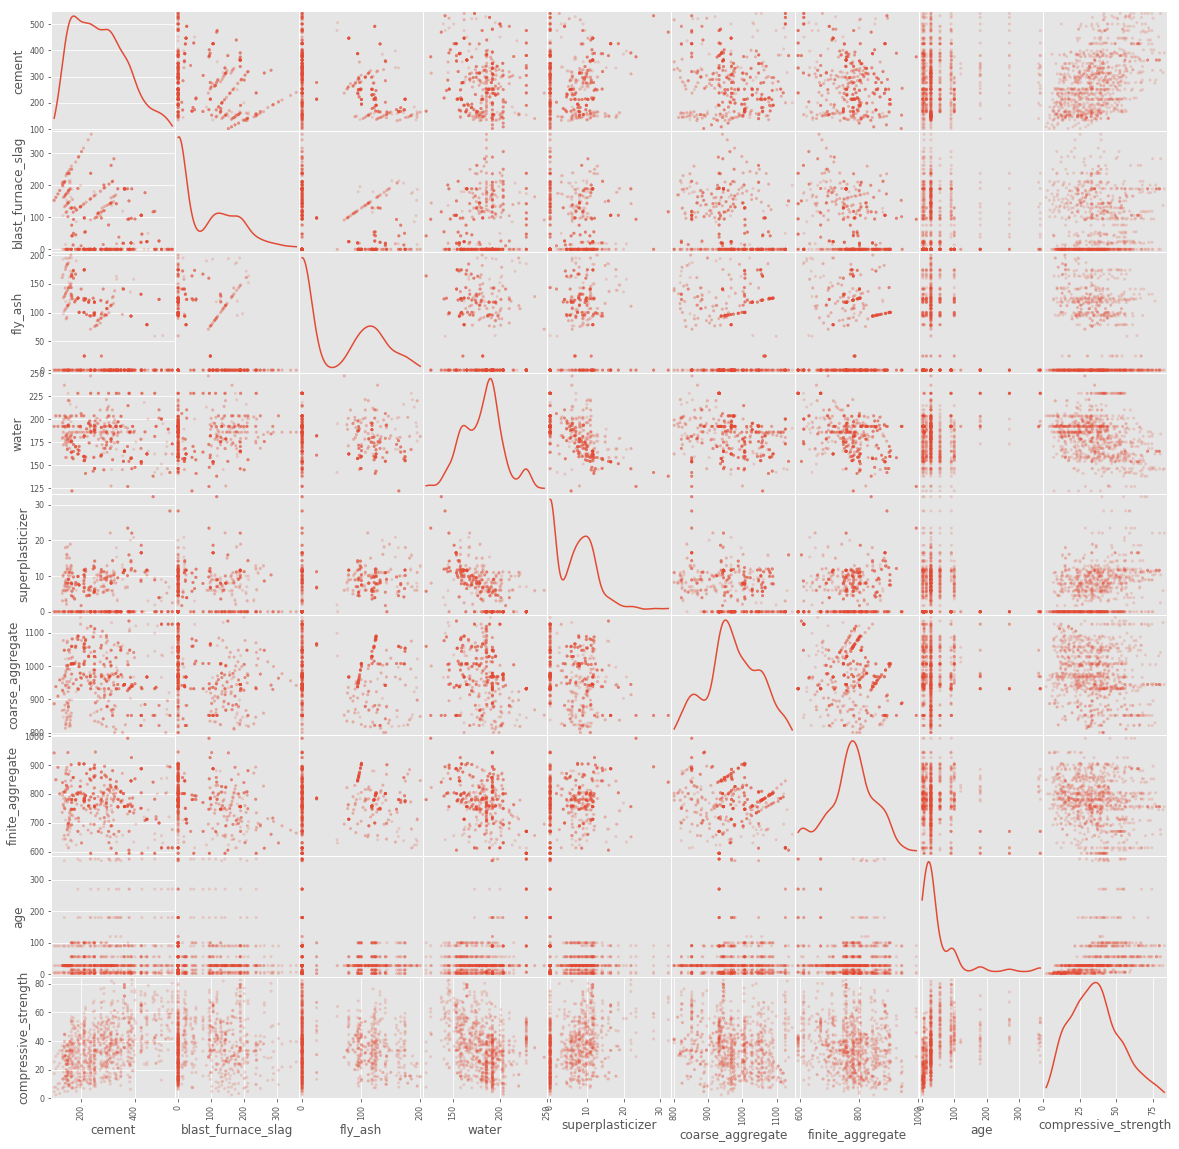

In [7]:
_ = scatter_matrix(concrete, alpha=0.2, figsize=(20, 20), diagonal='kde')

In the last row of this table, we have scatterplots showing the univariate relationships between our outcome variable and our various predictors.  There are a few predictors that show a strong relationship to the compressive strength, and some others that don't show much evidence of a relationship.

Also interesting are some relationships *between* the predictors we have available.  For example, `cement` and `blast_furnace_slag` show some interesting patters when compared:

Text(0,0.5,'blast_furnace_slag')

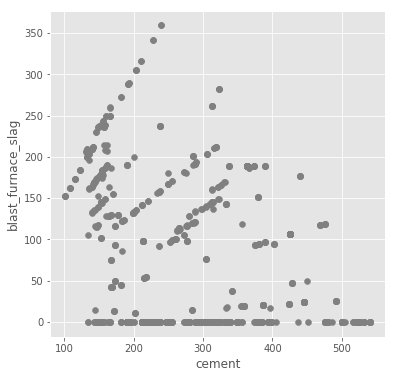

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(concrete["cement"], concrete["blast_furnace_slag"], color="grey")
ax.set_xlabel("cement"); ax.set_ylabel("blast_furnace_slag")

Text(0,0.5,'blast_furnace_slag')

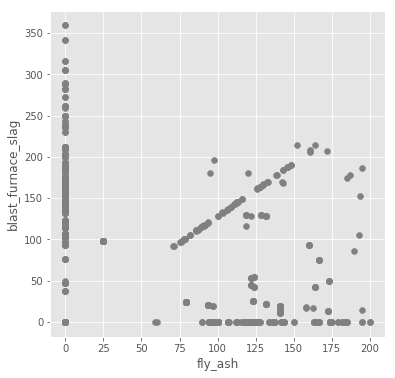

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(concrete["fly_ash"], concrete["blast_furnace_slag"], color="grey")
ax.set_xlabel("fly_ash"); ax.set_ylabel("blast_furnace_slag")

Strong relationships like this can create unexpected patterns in the fit model that *do not* reflect the univariate relationships between a predictor and the response.  We will have to watch out for this.

## Basis Expansions

To capture non-linearities in regression models, we need to transform some or all of the predictors.  To avoid having to treat every predictor as a special case needing detailed investigation, we would like some way of applying a very general *family* of transformations to our predictors. The family should be flexible enough to adapt (when the model is fit) to a wide variety of shapes, but not *too* flexible as to overfit before adapting itself to the shape of the signal being modeled.

This concept of a family of transformations that can fit together to capture general shapes is called a **basis expansion**.  The word *basis* here is used in the linear algebraic sense: a linearly independent set of objects.  In this case our objects are *functions*:

$$ B = \{ f_1, f_2, \ldots, f_k \} $$

and we create new sets of features by applying every function in our basis to a single raw feature:

$$ f_1(x), \ f_2(x), \ \ldots, \ f_k(x) $$


### Polynomial Basis

We have already encountered the **polynomial basis** used in polynomial regression.

In [10]:
def plot_basis(axs, basis_expansion, t):
    basis = basis_expansion.fit_transform(t)
    for idx, ax in enumerate(axs.flatten()):
        ax.plot(t, basis[:, idx])

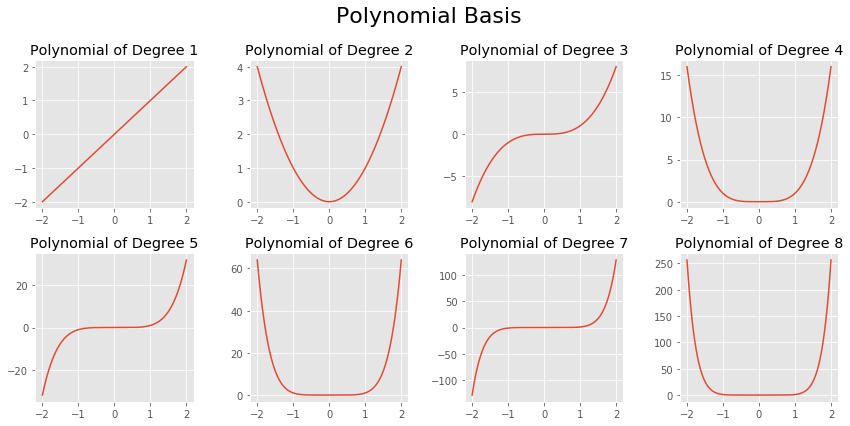

In [11]:
poly = Polynomial(degree=10)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
plot_basis(axs, poly, np.linspace(-2, 2, num=1000))

for i, ax in enumerate(axs.flatten(), start=1):
    ax.set_title("Polynomial of Degree {}".format(i))

fig.suptitle("Polynomial Basis", fontsize=22)
fig.tight_layout(rect=[0, 0.0, 1.0, 0.92])

Adding predictors to a regression using the polynomial basis allows us to capute non-linear relationships between $x$ and $y$.

![Polynomial Fits](images/polynomial-fits.png)

Polynomial basis expansions are the most commonly introduced in introductory courses in predictive modeling, but [they have some poor properties](http://madrury.github.io/jekyll/update/statistics/2017/08/04/basis-expansions.html) which makes them sub-optimal as a general purpose tool.  Better options are the Piecewise Linear and Piecewise Cubic splines discussed below.

### Piecewise Linear Basis

A piecewise linear spline is a functions that is always linear, except at distinct points where the slope of the line may change abruptly.

![Piecewise Linear Spline](images/pl-spline.png)

These points of abrupt change are called **knots**.

To fit a natural cubic spline to a set of data, we use a **piecewise linear spline basis**

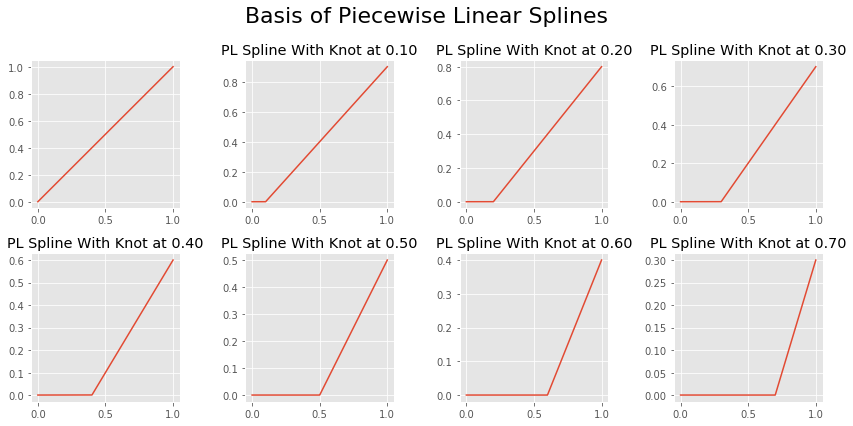

In [12]:
lin = LinearSpline(min=0, max=1, n_knots=9)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
plot_basis(axs, lin, np.linspace(0, 1, num=1000))

knots = lin.knots
for knot, ax in zip(knots, axs.flatten()[1:]):
    ax.set_title("PL Spline With Knot at {:2.2f}".format(knot))

fig.suptitle("Basis of Piecewise Linear Splines", fontsize=22)
fig.tight_layout(rect=[0, 0.0, 1.0, 0.92])

We can fit a piecewise linear curve to a set of data by passing a predictor through a basis of piecewise linear splines, and then using the resulting new columns as predictors in a linear regression.

![pl-fits](images/pl-fits.png)

Piecewise linear splines are simple and flexible, and are good choices for many predictive modeling applications.  Thier only major drawback is the 'pointyness', which we generally do not suspect will be a feature of most phenomina we study.  To this end, a more complex version of the same idea is often employed in practice.

## Concrete Data: Univariate Relationships

When we are building a predictive regression model, we are really interested not in the relationships amongst the features, but ther relationship of the features **to the target**.  This means that the most important of these scatterplots are the ones that compare the features to the target.

**A word of warning**: the relationship between a single feature and the target, when looked at in isolation, is not necessarily representative of what we will see when we take into account all of the predictors at once.  It is totally possible that the shapes we see in these visualization are **not** representative of what is really going on when **all** the feautures are taken into account.  

Yet, they do give us the best clues we have available for how to treat the variables in our regression.

To get a look at the univariate effect of a variable on the response, we will overlay a **linear spline** fit to the $(x, y)$ relationship over a scatterplot.

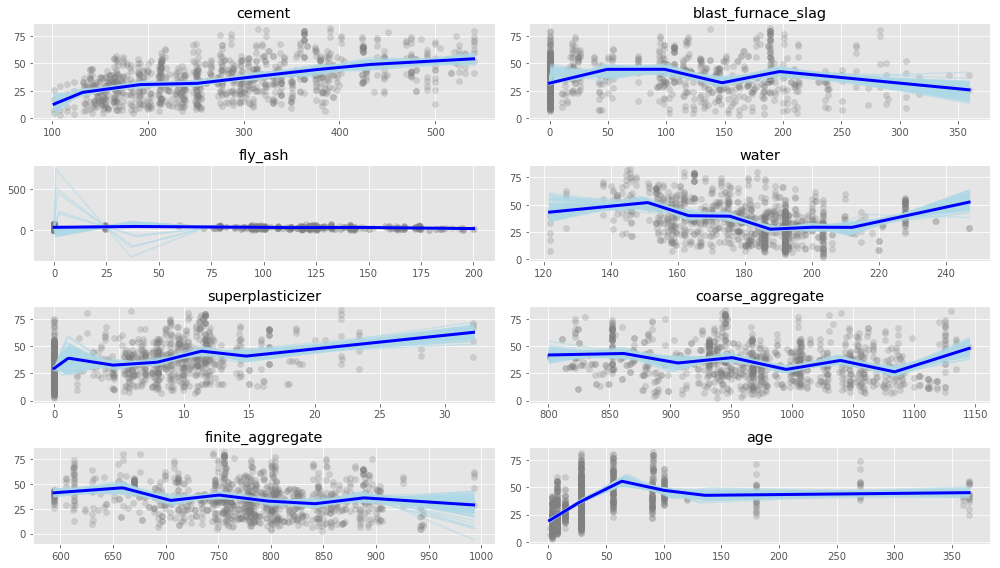

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(14, 8))
univariate_plot_names = concrete.columns[:-1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax,
                           concrete[name].values.reshape(-1, 1),
                           concrete['compressive_strength'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

To get a good feel for the stability of the shapes, we have fit our splines to many *bootstrap samples* of our dataset.  We plotted each spline fit to a bootstrap sample as a thing light blue line, which taken together create a band around the spline fit to the entire dataset.

## How Will We Treat These Variables in Regression

Let's look through each of these plots for evidence on how to treat these features in a regression model.

For each feature we will study the univariate effect, then create a `Pipeline` object that captures how we would like to fit the feature in our regression.

In [14]:
def plot_one_univariate(ax, var_name, mask=None, bootstrap=100):
    if mask is None:
        plot_univariate_smooth(
            ax,
            concrete[var_name].values.reshape(-1, 1), 
            concrete['compressive_strength'],
            bootstrap=bootstrap)
    else:
        plot_univariate_smooth(
            ax,
            concrete[var_name].values.reshape(-1, 1), 
            concrete['compressive_strength'],
            mask=mask,
            bootstrap=bootstrap)

### Cement

Text(0.5,1,'cement')

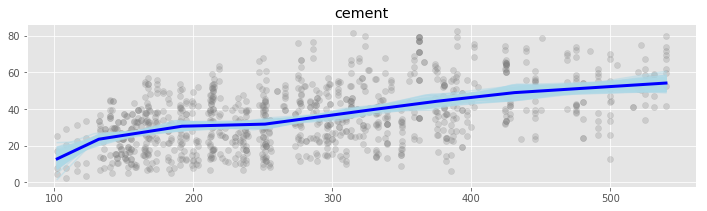

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
plot_one_univariate(ax, "cement")
ax.set_title("cement")

There is not much evidence that fitting anything other than a line is justified.

None the less, there is an important point to be made.  We can always be fooled with a single feature (univariate) look at the data,  it may be that when combined with the effect of the OTHER features, a more flexible fit than a line is the correct choice. So we **almost always** want to allow the fit of a feature to have some flexibility.

Later on we will discuss a very useful method called **regularization** that will allow us to discover exactly how flexible we should make our fits.

A spline with three knots is a good compromise in situations like this.  A three knot spline allows for two changes in slope, if neccessary.

In [50]:
cement_fit = Pipeline([
    ('cement', ColumnSelector(name='cement')),
    ('cement_spline', LinearSpline(knots=[200, 300, 400]))
])

A **pipeline** object contains instructons for transforming a numpy array of pandas data frame.  In this example, we select the `cement` column from our data frame, and then create a basis of natureal cubic splines with the described knots.

Pipeline objects have a **transform** method that consumes the raw data, and applies the transformations inside the pipeline in sequence.  Here's how that looks for our data frame.

In [51]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,finite_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [52]:
cement_fit.transform(concrete).head()

,cement_spline_linear,cement_spline_0,cement_spline_1,cement_spline_2
0,540.0,340.0,240.0,140.0
1,540.0,340.0,240.0,140.0
2,332.5,132.5,32.5,0.0
3,332.5,132.5,32.5,0.0
4,198.6,0.0,0.0,0.0


### Age

The relationship between the age of the cement, and the compressive strength is highly non-linear.

Text(0.5,1,'age')

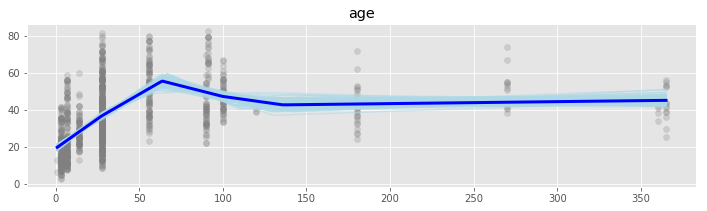

In [19]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "age")
ax.set_title('age')

There are two major things that jump out from this plot:

  - The values of `age` tend to group together into clusters.  This could be for any number of reason.  The ages could *actually* cluster like this, or this could be a simple reflection of how the ages were documented.
  - The mean values of `compressive_strength` change in a complicated way as `age` changes.
  
We have a couple of options for how to specify `age` in the model.

  - We could create **indicator variables** for each cluster of `age`.  This would allow the model to fit the *exact mean* of `compressive_strength` in each cluster of `age`.
  - We could fit a spline with some intelligently chosen knots.
  
The first option has some issues.  For one, we would end up fitting a large number of parameters for this one variable, which can lead to overfitting (which we will study in detail later).  This would also make it difficult for us to make predictions when we observe values of `age` that are *not* one of the discrete values measured in the training data.  Finally, as shown [here](http://madrury.github.io/jekyll/update/statistics/2017/08/04/basis-expansions.html), using indicator variables just generally causes models to have worse generalization properties than those using splines.

We'll stick to the theme, and create a spline, but use lots of knots since there is a lot of complexity in the scatterplot.

In [53]:
age_fit = Pipeline([
    ('age', ColumnSelector(name='age')),
    ('finite_add_spline', LinearSpline(knots=[25, 50, 75, 100, 150]))
])

### Blast Furnace Slag

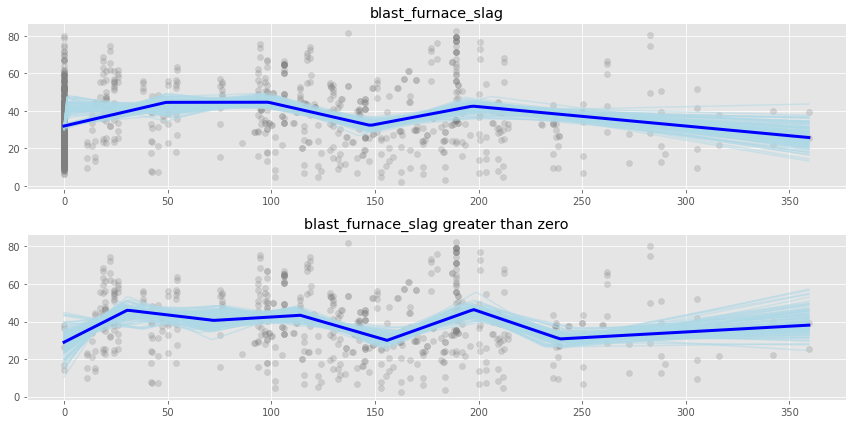

In [54]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_one_univariate(axs[0], "blast_furnace_slag")
axs[0].set_title("blast_furnace_slag")

plot_one_univariate(axs[1], "blast_furnace_slag", 
                    mask=(concrete['blast_furnace_slag'] > 0))
axs[1].set_title("blast_furnace_slag greater than zero")
fig.tight_layout()

The most interesting new feature here is that there is **a lot** of data with value zero, and this seems to be associated with a lower value of `compressive_strength` than would otherwise be expected.  

The rest of the data does not tell a straightforward story.  There *may* be a trend, but there may not.  Let's give the model some flexibility, which we can walk back later if we end up not needing it.

Taking this into account, we will use a single indicator variable, and a spline to fit this feature:

  - An indicator variable for `blast_furnace_slag == 0`.
  - A spline for the overall trend of `blast_furnace_slag`.
  
This type of fit allows the spline to capture the shape of the effect of having a **non-zero** amount of slag, since the indicator variable captures all of the zero effect.

In [58]:
slag_fit = Pipeline([
    ('slag', ColumnSelector(name='blast_furnace_slag')),
    # A Feature Union allows us to combine two completely seperate 
    # sets of features into a single data frame.  Here we are combining:
    #   - An indicator variable for slag == 0.0.
    #   - A Linear spline basis expansion (multiple new features)
    ('slag_features', FeatureUnion([
        # MapFeature allows us to use a function on a column to create a new feature.
        ('zero_slag', MapFeature(lambda slag: slag == 0.0, 'zero_slag')),
        ('slag_spline', LinearSpline(
            knots=[35, 75, 100, 150, 200, 250]) )  
    ]))
])

Notice how, once we transform the data, we get a new feature which is `0.0` or `1.0` depending on if slag is **exactly** zero, and a set of spline features.

In [60]:
slag_fit.transform(concrete).head()

,zero_slag,blast_furnace_slag_spline_linear,blast_furnace_slag_spline_0,blast_furnace_slag_spline_1,blast_furnace_slag_spline_2,blast_furnace_slag_spline_3,blast_furnace_slag_spline_4,blast_furnace_slag_spline_5
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,142.5,107.5,67.5,42.5,0.0,0.0,0.0
3,0.0,142.5,107.5,67.5,42.5,0.0,0.0,0.0
4,0.0,132.4,97.4,57.4,32.4,0.0,0.0,0.0


### Fly Ash

Text(0.5,1,'fly_ash')

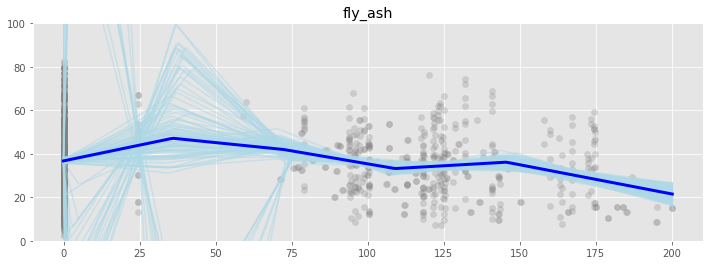

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_one_univariate(ax, "fly_ash")
ax.set_ylim(0, 100)
ax.set_title("fly_ash")

Another similar case to the `blast_furnace_slag`, there is a strong cluster of records with a value of zero.  

The small cluster at `25` seems innocent, but the are **high leverage** points.  High leverage points are those that exhibit an unreasonably strong effect on the regression.  You can see this in the chaotic behaviour of all the thin blue lines fit to subsamples of the data!

If we the cluster at around `25` unattended to, they may exhibit a large effect on the shape of the regression we hope to fit to the rest of the data.  For this reason, we will also add an indicator variable for `fly_ash == 25.0`.

There is not much evidence for anything more complicated than linear variation in the large cluster of data to the right of the plot (in the `>= 75` region), so as usual, we will use a spline with three knots in case the univariate picture is not telling us the whole story.

In [62]:
fly_ash_fit = Pipeline([
    ('fly_ash', ColumnSelector(name='fly_ash')),
    ('fly_ash_features', FeatureUnion([
        ('zero_fly_ash', MapFeature(lambda ash: ash == 0.0, 'zero_fly_ash')),
        ('twenty_five_fly_ash', MapFeature(
            lambda ash: (ash >= 24.0) & (ash <= 26.0), 'twenty_five_fly_ash')),
        ('fly_ash', LinearSpline(knots=[100, 125, 150, 175]))  
    ]))
])

### Water

Text(0.5,1,'water')

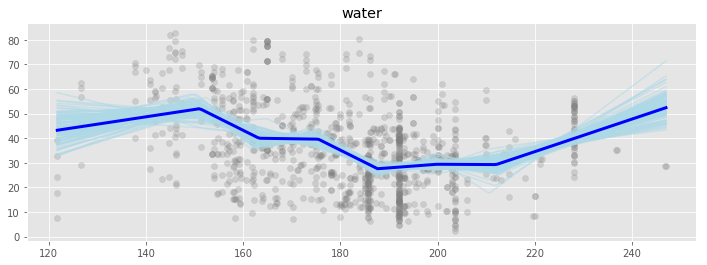

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_one_univariate(ax, "water")
ax.set_title('water')

Water is an interesting feature.  It looks like too little water harms the compressive strength of a concrete, as does too much water, with a perfect level somewhere in the middle.  It looks like the engineers *know* this, as evidenced by the large accumulation of points at around `190`, which is very close to the sweet spot.

We would like to capture this trend, so let's use a few knots to allow for a flexible shape.

In [64]:
water_fit = Pipeline([
    ('water', ColumnSelector(name='water')),
    ('water_spline', LinearSpline(knots=[140, 160, 180, 200, 220]))
])

### Superplasticizer

Text(0.5,1,'superplasticizer')

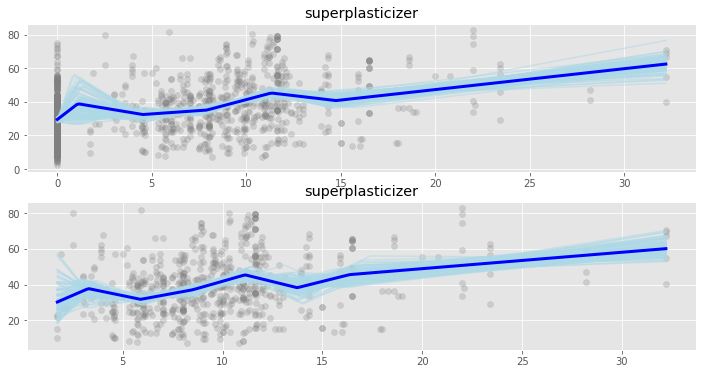

In [65]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_one_univariate(axs[0], "superplasticizer")
axs[0].set_title('superplasticizer')

plot_one_univariate(axs[1], "superplasticizer",
                    mask=(concrete['superplasticizer'] > 0))
axs[1].set_title('superplasticizer')

Here, again, we need an indicator variable for the many records which assume that value zero.

For the non-zero records, it looks like there may be some non-linearity in the trend, so we will do our usual and use a three knot spline.

In [66]:
superplasticizer_fit = Pipeline([
    ('superplasticizer', ColumnSelector(name='superplasticizer')),
    ('superplasticizer_features', FeatureUnion([
        ('zero_superplasticizer', 
            MapFeature(lambda plast: plast == 0.0, 'zero_superplasticizer')),
        ('superplasticizer_spline', 
            LinearSpline(knots=[5, 10, 15]))  
    ]))
])

### Course Aggregate

Text(0.5,1,'coarse_aggregate')

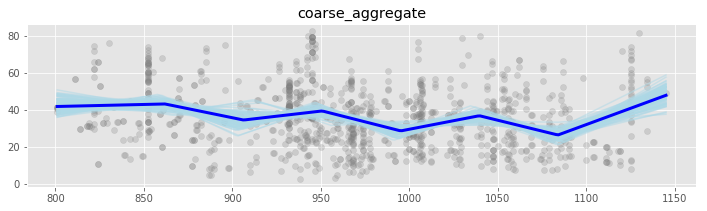

In [67]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "coarse_aggregate")
ax.set_title('coarse_aggregate')

Looks like a clear cut three knots situation.

In [68]:
coarse_agg_fit = Pipeline([
    ('coarse_agg', ColumnSelector(name='coarse_aggregate')),
    ('course_add_spline', LinearSpline(knots=[900, 950, 1000, 1050]))
])

### Finite Aggregate

Text(0.5,1,'finite_aggregate')

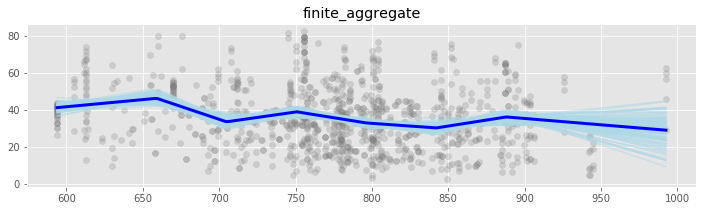

In [69]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "finite_aggregate")
ax.set_title('finite_aggregate')

In [70]:
finite_agg_fit = Pipeline([
    ('finite_agg', ColumnSelector(name='finite_aggregate')),
    ('finite_add_spline', LinearSpline(knots=[900, 950, 1000, 1050]))
])

### Constructing All the Features

We now have a `Pipeline` for each feature in the regression, we can now use the `FeatureUnion` class to put everything together into final feature construction object.

In [71]:
feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('cement_fit', cement_fit),
    ('slag_fit', slag_fit),
    ('fly_ash_fit', fly_ash_fit),
    ('water_fit', water_fit),
    ("superplasticizer_fit", superplasticizer_fit),
    ("coarse_agg_fit", coarse_agg_fit),
    ("finite_agg_fit", finite_agg_fit),
    ("age_fit", age_fit)
])

We can call `.fit` and `.transform` on this final object to create a new data frame containing all of our features.

In [72]:
feature_pipeline.fit(concrete)
features = feature_pipeline.transform(concrete)

In [73]:
features.head()

,intercept,cement_spline_linear,cement_spline_0,cement_spline_1,cement_spline_2,zero_slag,blast_furnace_slag_spline_linear,blast_furnace_slag_spline_0,blast_furnace_slag_spline_1,blast_furnace_slag_spline_2,...,finite_aggregate_spline_0,finite_aggregate_spline_1,finite_aggregate_spline_2,finite_aggregate_spline_3,age_spline_linear,age_spline_0,age_spline_1,age_spline_2,age_spline_3,age_spline_4
0,1.0,540.0,340.0,240.0,140.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28.0,3.0,0.0,0.0,0.0,0.0
1,1.0,540.0,340.0,240.0,140.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28.0,3.0,0.0,0.0,0.0,0.0
2,1.0,332.5,132.5,32.5,0.0,0.0,142.5,107.5,67.5,42.5,...,0.0,0.0,0.0,0.0,270.0,245.0,220.0,195.0,170.0,120.0
3,1.0,332.5,132.5,32.5,0.0,0.0,142.5,107.5,67.5,42.5,...,0.0,0.0,0.0,0.0,365.0,340.0,315.0,290.0,265.0,215.0
4,1.0,198.6,0.0,0.0,0.0,0.0,132.4,97.4,57.4,32.4,...,0.0,0.0,0.0,0.0,360.0,335.0,310.0,285.0,260.0,210.0


## Fitting a Regression and Investigating the Results

Now that we have all our features transformed and ready to go, fitting the model is easy.

**Note:** Since we included an intercept term in our model specification, we must pass `fit_intercept=False` when creating our `LinearRegression` object.

In [74]:
features.values

array([[   1. ,  540. ,  340. , ...,    0. ,    0. ,    0. ],
       [   1. ,  540. ,  340. , ...,    0. ,    0. ,    0. ],
       [   1. ,  332.5,  132.5, ...,  195. ,  170. ,  120. ],
       ..., 
       [   1. ,  148.5,    0. , ...,    0. ,    0. ,    0. ],
       [   1. ,  159.1,    0. , ...,    0. ,    0. ,    0. ],
       [   1. ,  260.9,   60.9, ...,    0. ,    0. ,    0. ]])

In [75]:
model = LinearRegression(fit_intercept=False)
model.fit(features.values, y=concrete['compressive_strength'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

We can easily look at the fit coefficients from our model.  These are hard to interpret in the case of our spline terms, but the following **partial dependency plots** will help.

In [76]:
display_coef(model, features.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
intercept                          -219.20657608170418 
cement_spline_linear               0.1600237864018074  
cement_spline_0                    -0.027100525208324122
cement_spline_1                    -0.028917725726288604
cement_spline_2                    0.025481953192122184
zero_slag                          1.5840165956078445  
blast_furnace_slag_spline_linear   0.10588837916468877 
blast_furnace_slag_spline_0        0.20390723087730006 
blast_furnace_slag_spline_1        -0.4380364578352049 
blast_furnace_slag_spline_2        0.2180674494259786  
blast_furnace_slag_spline_3        0.03907099396951287 
blast_furnace_slag_spline_4        -0.07670300070515967
blast_furnace_slag_spline_5        -0.05381646439608842
zero_fly_ash                       15.381824497115556  
twenty_five_fly_ash                17.819149811104595  
fly_ash_spline_linear              0.218643469

### Bootstrap to Get a Feel for How the Coefficients Vary

It's good to get a sense of how sensitive the coefficients we fit are to the data.  This can allow us to make statement about how sure we are that certain effects are real. This may also allow us to simplify our model (though regularization is a better approach for this).

To construct the histograms below, we did the following:

  - Take 1000 bootstrap samples (samples with replacemet of the same size of the original data) from our training data:
  - For every bootstrap sample:
    - Fit a regression (with the same features) to the bootstrap sample.
    - Record the parameter estimates from the fit regression.
  - Plot a histogram of the bootstrapped parameter estimates for each feature.
  
Bootstrapping may have seemed silly when we first introduced it, as we only utilized it to create distributions of very simple sample statistics.  In this case, the fit parameters are a *very complicated* sample statistic, it would be extremely difficult to compute by hand their distribution.  Bootstrapping makes it easy to get a sense for how sensitive they our to our training data.

In [77]:
# This creates a list of models, one for each bootstrap sample.
models = bootstrap_train(
    LinearRegression, 
    features.values, 
    concrete['compressive_strength'],
    fit_intercept=False
)

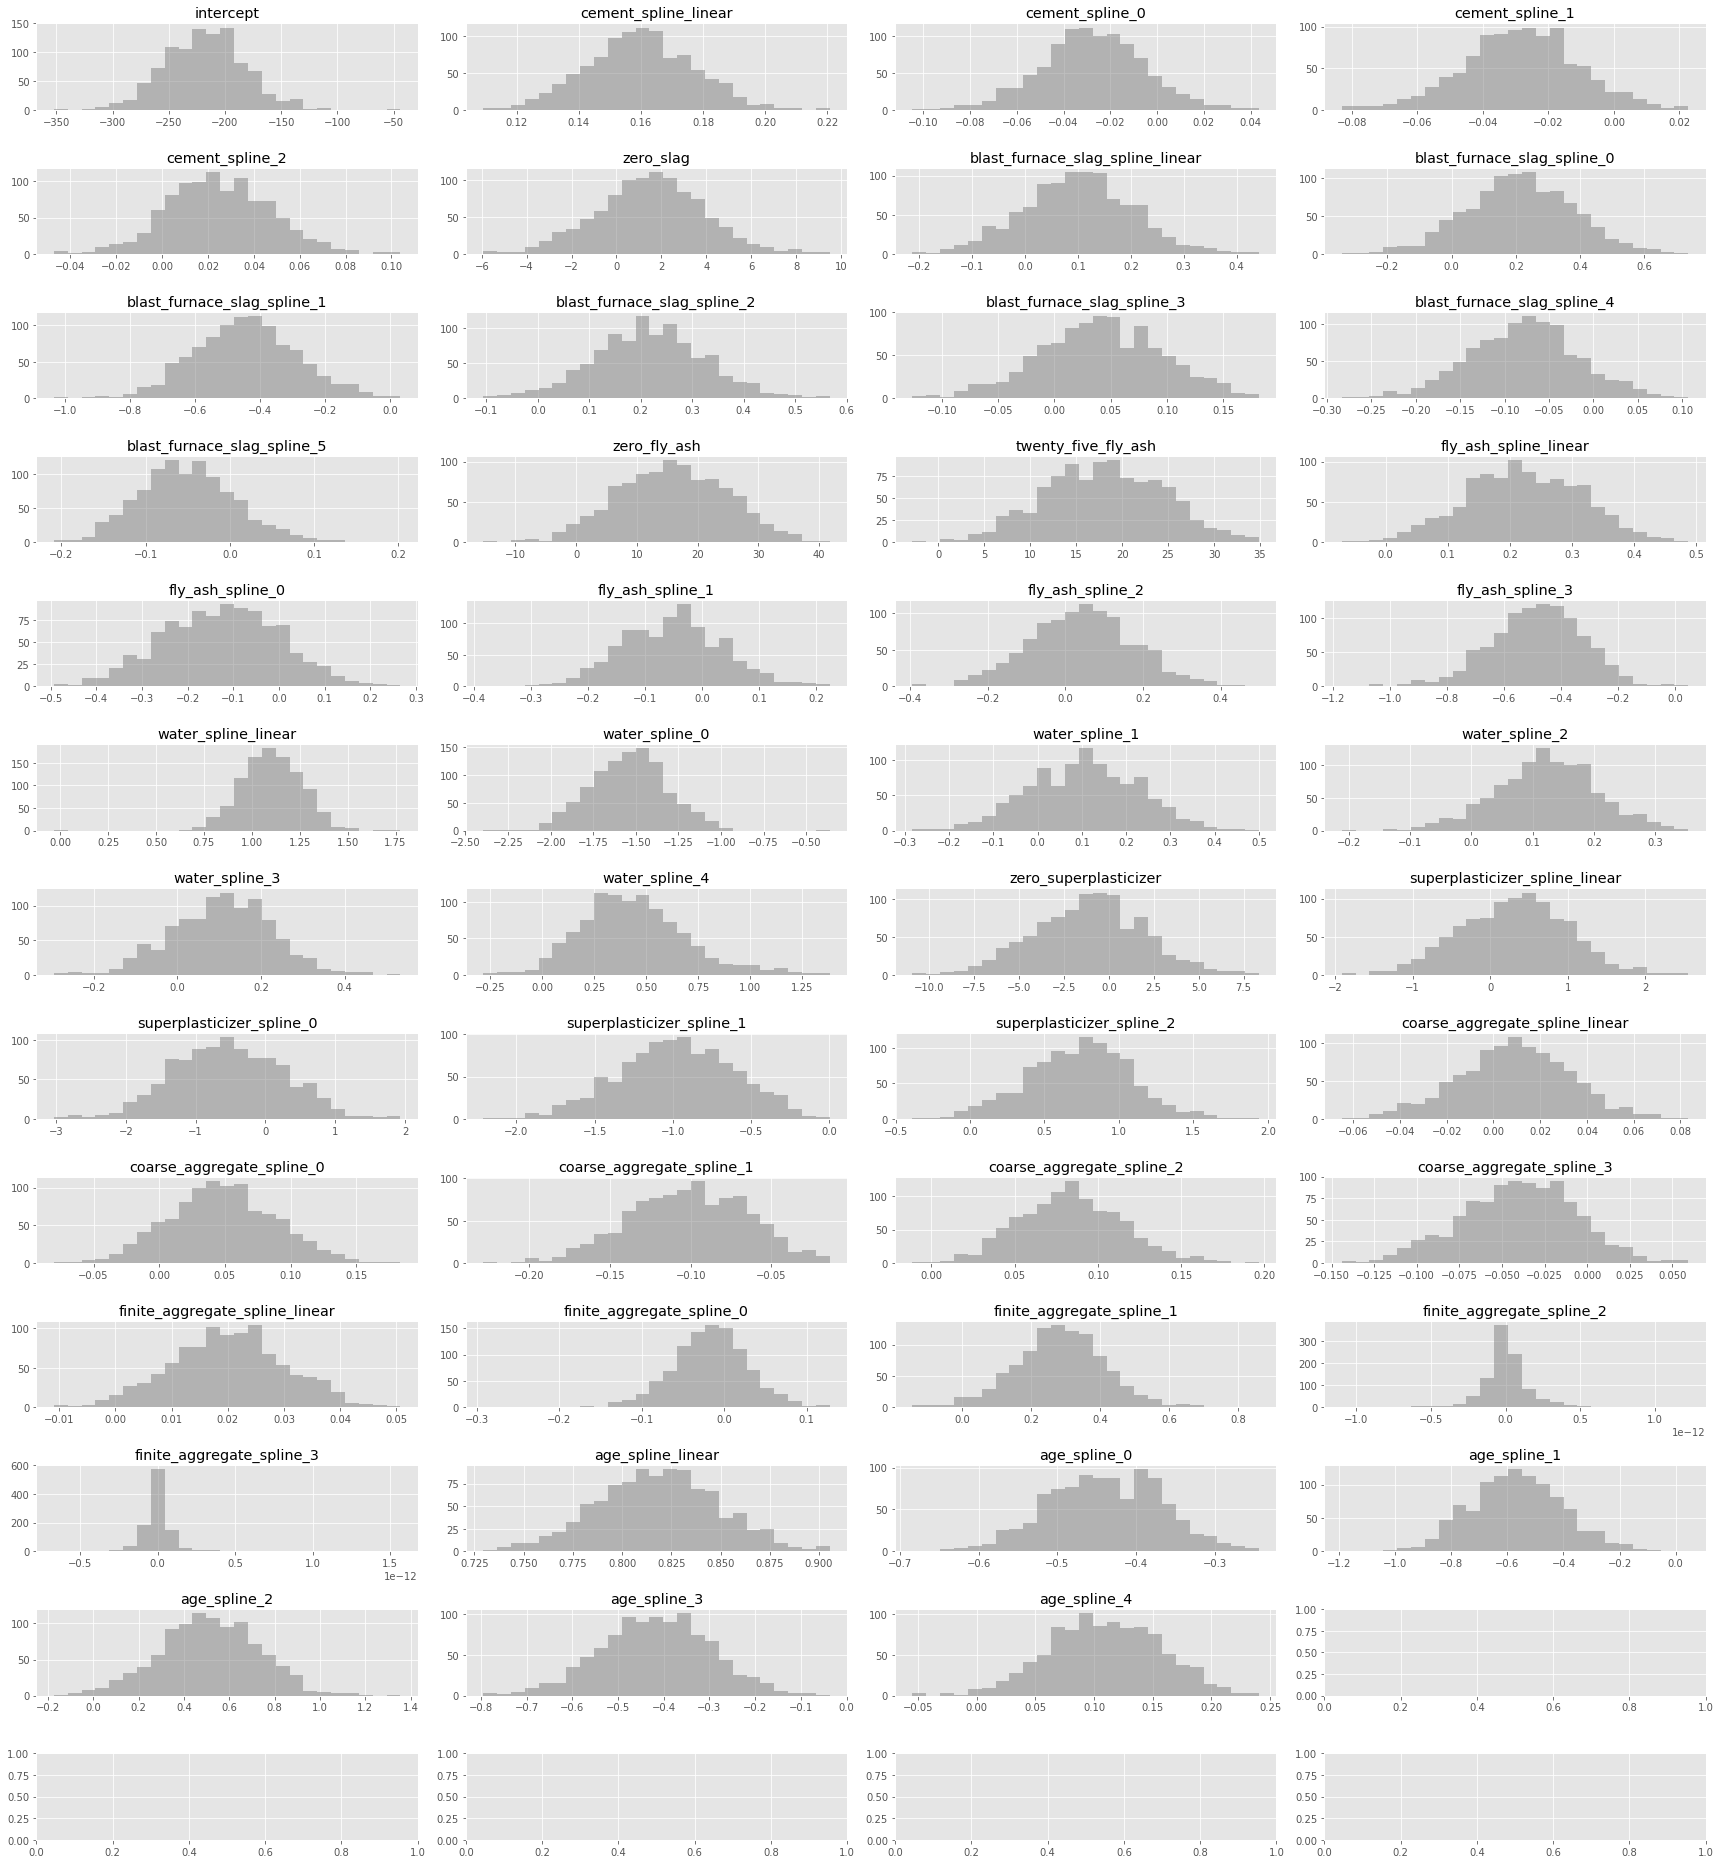

In [78]:
fig, axs = plot_bootstrap_coefs(models, features.columns, n_col=4)
fig.tight_layout()

### Predicted vs. Actuals by Variables

A simple thing we can do to get a feel for how our model is doing is to plot the actual and predicted values of `compressive_strength` against eachother.

In the following plots, we have displayed a scatterplot of `compressive_strength` against each of the features in our model.  Overlayed, we have plotted the *mean* predicted value in different intervals of the given variable.  That is, to create the plots we have:

  - Plotted a scatterplot of the variable vs. the response.
  - Bucketed the variable into 25 equally spaced segments.
  - Calculated the mean predicted value of the response across all of the data points in the bucket.
  - Plotted the mean predicted values at the center of each bucket, and then connected with lines to help highlight any trends.
  
If our model fits the data well, we should see that the trend of mean predicted values generally follows the trend of the scatterplot.

**Important**: Its very crucial to realize that the predicted values in this plot take into account **all** of the predictors in the model, not just the predictor being shown on the x-axis.  This is why the trend in predicted values is not smooth, even though our fit of each predictor *is* smooth.

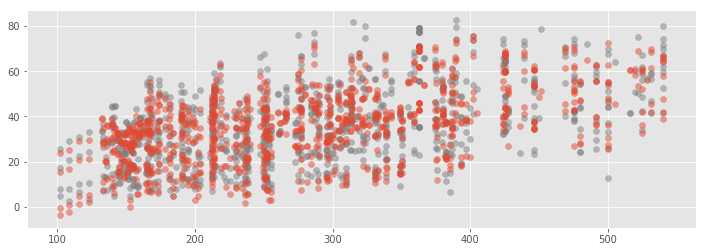

In [80]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(concrete['cement'], concrete['compressive_strength'], color="grey", alpha=0.5)
ax.scatter(concrete['cement'], model.predict(features.values), alpha=0.5)

In [81]:
def plot_many_predicteds_vs_actuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = concrete[name]
        predicteds_vs_actuals(ax, x, concrete["compressive_strength"], y_hat, n_bins=n_bins)
        ax.set_title("{} Predicteds vs. Actuals".format(name))
    return fig, axs

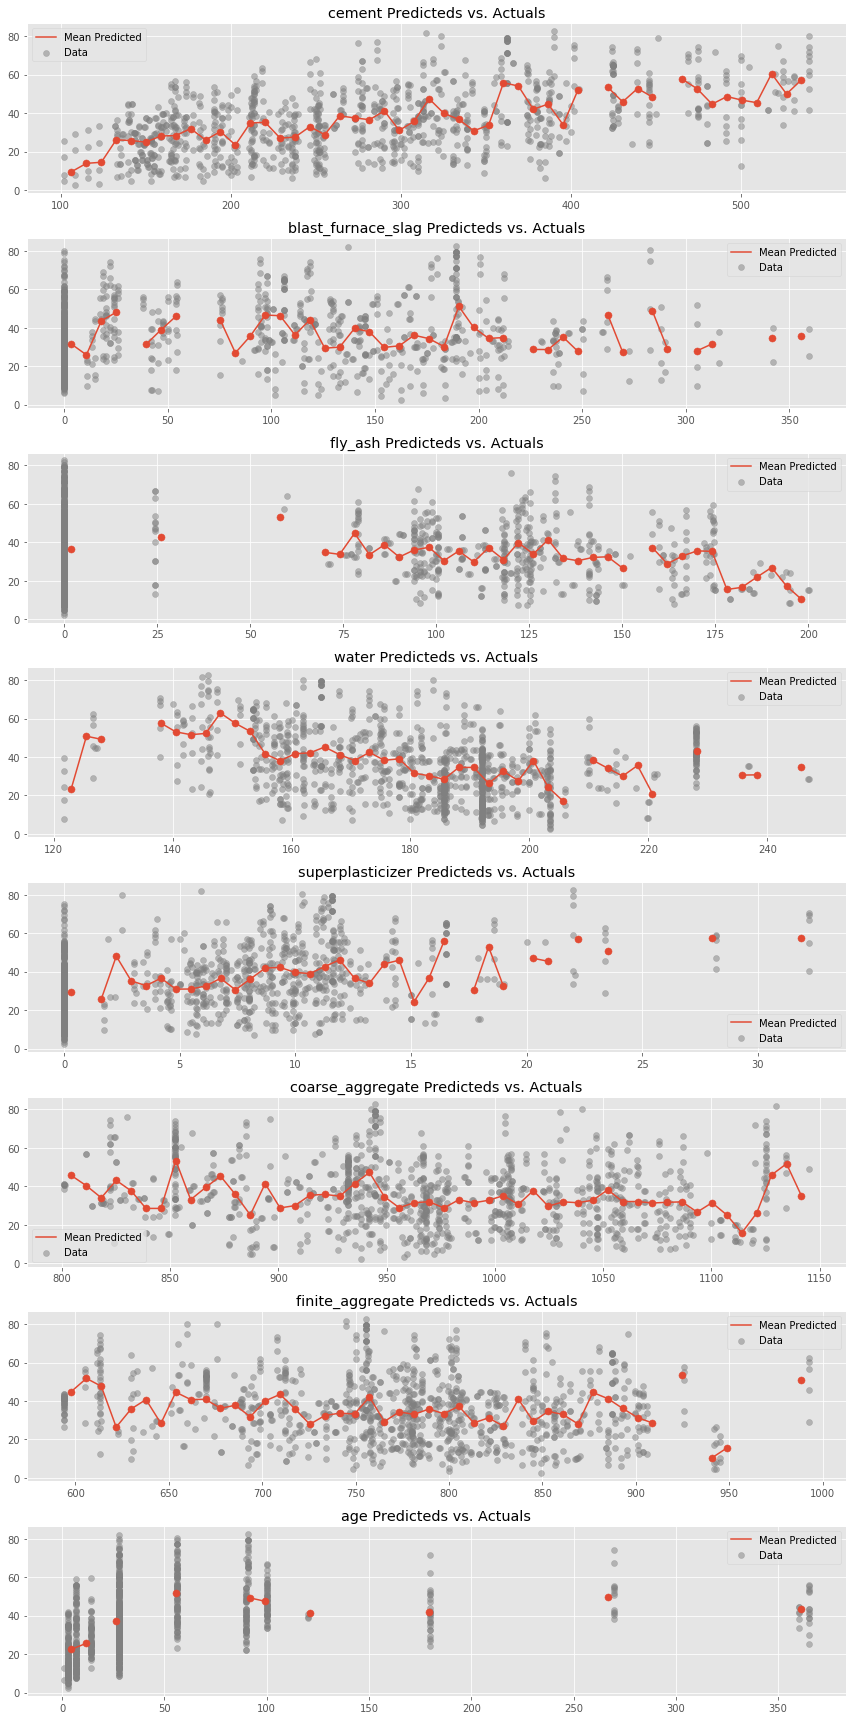

In [82]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
y_hat = model.predict(features.values)
fig, axs = plot_many_predicteds_vs_actuals(var_names, y_hat)
fig.tight_layout()

### Residuals by Variable

A similar type of plot, though with a bit more detail, is a *residuals by variable* plot.  In these, we plot the residuals for each data point on the $y$-axis, against the values of a single feature on the $x$-axis.

If our model is well specified, we should see the values of the residuals in each of this plot relatively evenly spaced around zero, with no discernible patterns in the relationship between the plotted residuals, and the variable along the $x$-axis.

In [83]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

In [84]:
def plot_many_residuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = concrete[name]
        residual_plot(ax, x, concrete["compressive_strength"], y_hat)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

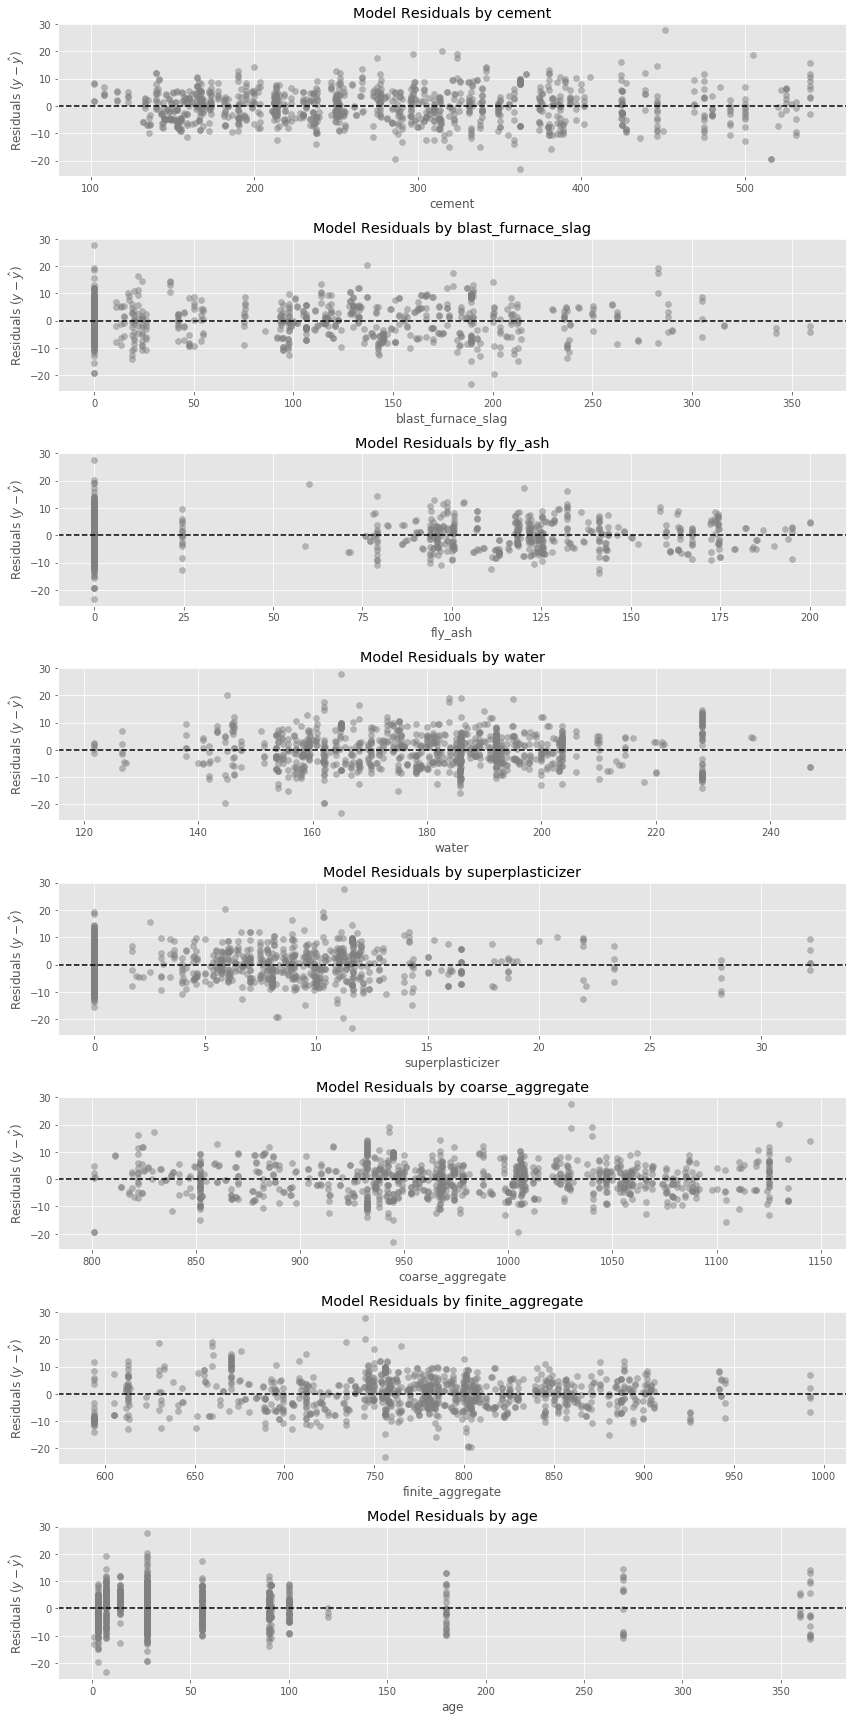

In [85]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
fig, axs = plot_many_residuals(var_names, y_hat)
fig.tight_layout()

### Model Residuals by Predicted Values

Another residual plot puts the *predicted values* along the $x$-axis.

Text(0.5,0,'$\\hat y$')

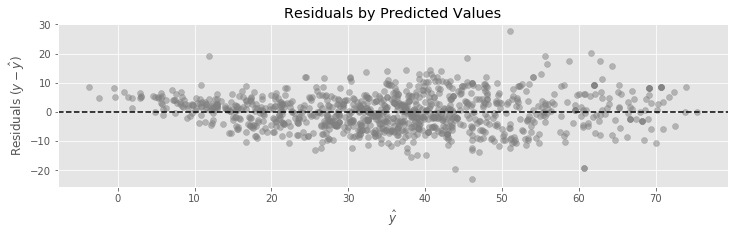

In [86]:
fig, ax = plt.subplots(figsize=(12, 3))
residual_plot(ax, y_hat, concrete["compressive_strength"], y_hat)
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")

If our model is well specified, we should see the values of the residuals in each of this plot relatively evenly spaced around zero, with no discernible patterns.

In this case, we see a hint that our model is missing something.  For small values of the predicted compressive strength, we have almost *all* of the data above the center line.  This seems to indicate that our model is lacking something.

**Note**: It is **not** really necessary that the width of the residual scatter stays *constant* as the value of the feature changes, as is often assumed.  This is only a necessary assumption for certain applications of regression, we will discuss this more this afternoon.

### Partial Dependence Plots for the Fit Effect of a Predictor

Finally, we return to the issue of interpreting the parameter estimates in our model when using more sophisticated transformations like splines.

In the simple situation where all of our features enter into the model untransformed, the meaning of the parameter estimates is simple

> If a untransformed feature receives a parameter estimate of $\hat \beta$, then the predicted values from the regression change by $\hat \beta$ when the value of the feature change by one unit, and the values of all other features in the model are held fixed.

I.e., if we pick some values for all the *other* features in the model, and change *only* the value of one feature, the predicted values from the model trace out a line, and the slope of the line is $\hat \beta$.

Of course, this does not work when we transform the features in our model: The path traced out when we hold all but the feature constant, and change the value of the feature is **not** a line, and hence cannot be summarized with only one number.

A **partial dependence plot** is exactly what is described above, we fix the values of all but one feature (we could use any values, but we choose to use the mean of the features), and trace out the curve formed by changing the values of the last remaining feature.

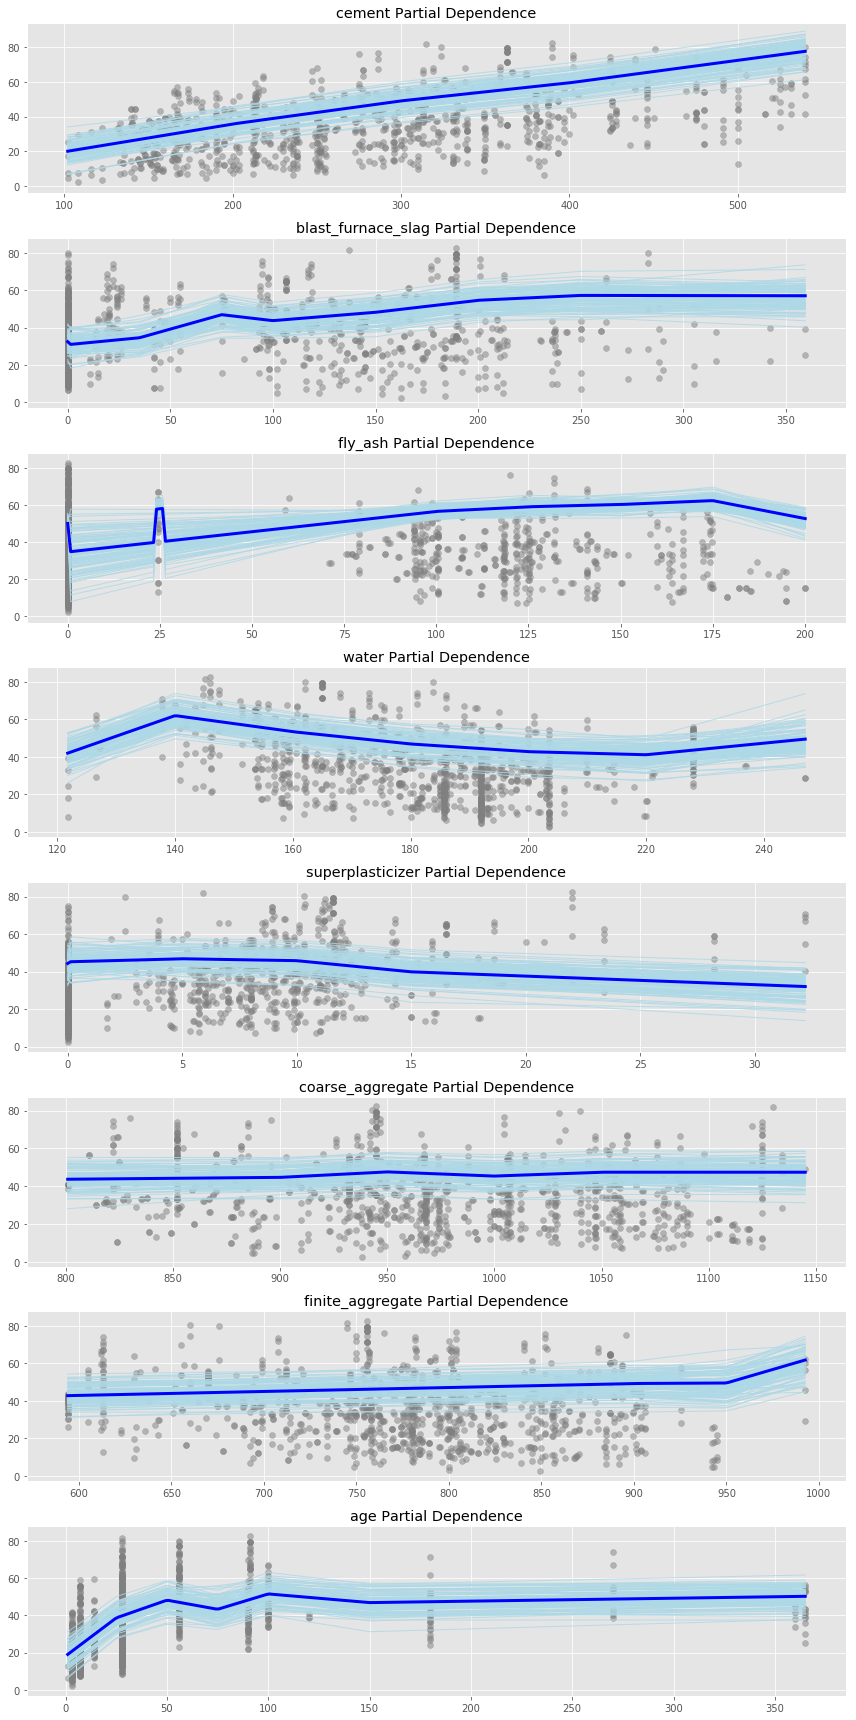

In [87]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
fig, axs = plot_partial_dependences(
     model, 
     X=concrete,
     var_names=var_names,
     pipeline=feature_pipeline,
     bootstrap_models=models,
     y=concrete["compressive_strength"])
fig.tight_layout()

Notice that the partial dependency plots do **not** necessarily follow the trend of data, not do they have to.  Because there are correlations between predictors, a feature may cooperate with *other* features to make good predictions.

Another way to say this is that our assumption that we can fix the values of all other predictors and change only one is not always sensible, as there are predictors that tend to change *together*.  This means that the partial dependence plot of a feature must not always capture the trend in the scatterplot of the feature vs. the response.